In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%matplotlib inline

In [10]:
df = pd.read_csv('../data/preprocessed_data.csv')

In [11]:
df.head()

,Winner,title_bout,no_of_rounds,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,...,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
0,Red,False,3,0.570801,0.3125,0.461431,0.504418,0.035756,0.143079,0.578613,...,0,1,0,0,0,0,0,0,0,1
1,Blue,False,3,0.000000,0.7500,0.411250,0.467500,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,1,0,0,0
2,Blue,False,3,0.000000,0.0000,0.560000,0.550000,0.280000,0.000000,1.000000,...,0,1,0,0,0,0,0,0,0,1
3,Red,False,3,0.000000,0.1250,0.220625,0.515000,0.108750,0.250000,0.062500,...,0,1,0,0,0,0,0,0,1,0
4,Red,False,3,0.500000,0.0000,0.590000,0.465000,0.000000,0.500000,0.000000,...,0,0,0,1,0,0,1,0,0,0


### Normalizing data

In [12]:
df_num = df.select_dtypes(include=[np.float, np.int])

In [13]:
scaler = StandardScaler()

df[list(df_num.columns)] = scaler.fit_transform(df[list(df_num.columns)])

In [14]:
with open('../models/standard.scaler', 'wb') as f:
    pickle.dump(scaler, f)

### Making target variable balanced

In [15]:
df['Winner'].value_counts()

Red     4525
Blue    2315
Name: Winner, dtype: int64

In [19]:
target_value = df['Winner'].value_counts().Red - ((df['Winner'].value_counts().Red + df['Winner'].value_counts().Blue) / 2)
target_value

1105.0

In [20]:
sample = df[df['Winner']=='Red'].sample(n=int(target_value))
df.drop(sample.index, inplace=True)

In [21]:
rename_cols = {}
for column in sample.columns:
    if column.startswith('B_'):
        rename_cols['B_' + column.split('B_', 1)[1]] = 'R_' + column.split('B_', 1)[1]
        rename_cols['R_' + column.split('B_', 1)[1]] = 'B_' + column.split('B_', 1)[1]

sample.rename(rename_cols, axis='columns', inplace=True)
sample.replace({'Winner': 'Red'}, 'Blue', inplace=True)

In [22]:
df = pd.concat([df, sample]).sort_index()

### Shuffling data

In [40]:
sample1 = df[df['Winner']=='Red'].sample(n=2000)
sample2 = df[df['Winner']=='Blue'].sample(n=2000)

df.drop(sample1.index, inplace=True)
df.drop(sample2.index, inplace=True)

In [41]:
rename_cols = {}
for column in sample.columns:
    if column.startswith('B_'):
        rename_cols['B_' + column.split('B_', 1)[1]] = 'R_' + column.split('B_', 1)[1]
        rename_cols['R_' + column.split('B_', 1)[1]] = 'B_' + column.split('B_', 1)[1]

sample1.rename(rename_cols, axis='columns', inplace=True)
sample2.rename(rename_cols, axis='columns', inplace=True)

In [42]:
sample1.replace({'Winner': 'Red'}, 'Blue', inplace=True)
sample2.replace({'Winner': 'Blue'}, 'Red', inplace=True)

In [43]:
df = pd.concat([df, sample1, sample2]).sort_index()

### Splitting into train, test

In [44]:
y = df['Winner']
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)
# y_test = label_encoder.transform(Test['Winner'])

X = df.drop(columns='Winner')
# X_test = Test.drop(columns='Winner')
# X_test = X_test[X.columns]

X_train, X_valid, y_train, y_valid = train_test_split(X, label_encoded_y, test_size=0.1, random_state=41)

### Fitting baseline Xgboost

In [45]:
def plot_confusion(cm, classes):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [46]:
def modelfit(alg, X_train, y_train, X_valid, y_valid, X_test=None, y_test=None,
             useTrainCV=False, test_set=False, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(f"Best number of estimators = {cvresult.shape[0]}")
    
    #Fit the algorithm on the data
    alg.fit(np.array(X_train), np.array(y_train), eval_metric='auc')
    
    #Predict train set:
    dtrain_predictions = alg.predict(np.array(X_train))
    dtrain_predprob = alg.predict_proba(np.array(X_train))[:,1]
        
    #Predict valid set:
    dvalid_predictions = alg.predict(np.array(X_valid))
    dvalid_predprob = alg.predict_proba(np.array(X_valid))[:,1]
    
    #Predict test set:
    dtest_predictions = None
    if test_set:
        dtest_predictions = alg.predict(np.array(X_test))
        dtest_predprob = alg.predict_proba(np.array(X_test))[:,1]
        
    #Print model report:
    print("\nModel Report: ")
    if useTrainCV:
        print(f"AUC Score (Train): {roc_auc_score(y_train, dtrain_predprob)}")
    print(f"Accuracy (valid): {accuracy_score(y_valid, dvalid_predictions):.4f}")
    print(f"AUC Score (valid): {roc_auc_score(y_valid, dvalid_predprob):.4f}")
    if test_set:
        print(f"Accuracy (Test): {accuracy_score(y_test, dtest_predictions):.4f}")
        print(f"AUC Score (Test): {roc_auc_score(y_test, dtest_predprob):.4f}")
    
    
    return dvalid_predictions, dtest_predictions

d:\Python\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report: 
Accuracy (valid): 0.6608
AUC Score (valid): 0.7199


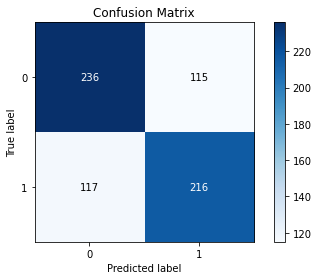

In [47]:
model1 = XGBClassifier(random_state=43, n_jobs=-1)

y1_valid_preds, y1_test_preds = modelfit(model1, X_train, y_train, X_valid, y_valid)

cm_valid = confusion_matrix(y_valid, y1_valid_preds)
# cm_test = confusion_matrix(y_test, y1_test_preds)
classes = unique_labels(y_valid, y1_valid_preds)

plot_confusion(cm_valid, classes)

In [48]:
feat_imps = {}
for i, imp in enumerate(model1.feature_importances_):
    feat_imps[X_train.columns[i]] = imp

sorted_imp_feats = (sorted(feat_imps.items(), key = lambda x: x[1], reverse=True))
sorted_imp_feats

[('B_avg_opp_KD', 0.056554094),
 ('R_avg_opp_KD', 0.03947),
 ('B_avg_opp_REV', 0.021943472),
 ('no_of_rounds', 0.011359561),
 ('B_win_by_Decision_Split', 0.010802321),
 ('B_avg_opp_DISTANCE_landed', 0.0097730225),
 ('R_age', 0.009403752),
 ('R_avg_GROUND_att', 0.009112607),
 ('B_age', 0.009094639),
 ('B_avg_opp_HEAD_landed', 0.009010224),
 ('R_avg_REV', 0.008936432),
 ('R_avg_opp_LEG_landed', 0.00864145),
 ('B_avg_REV', 0.008450942),
 ('B_avg_SIG_STR_att', 0.008286873),
 ('B_avg_opp_GROUND_landed', 0.008282392),
 ('B_avg_TOTAL_STR_att', 0.008233477),
 ('B_avg_TD_att', 0.008184783),
 ('B_Weight_lbs', 0.0080154855),
 ('R_avg_opp_DISTANCE_landed', 0.007998514),
 ('R_longest_win_streak', 0.007983037),
 ('R_avg_TOTAL_STR_att', 0.007971861),
 ('R_avg_opp_BODY_att', 0.0078555895),
 ('B_avg_CTRL_time(seconds)', 0.007795715),
 ('R_avg_opp_TOTAL_STR_landed', 0.00778228),
 ('R_Reach_cms', 0.00774813),
 ('R_avg_KD', 0.007703426),
 ('R_losses', 0.0076484643),
 ('weight_class_Welterweight', 0.007503

### Hyperparameter tuning 

d:\Python\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report: 
Accuracy (valid): 0.6740
AUC Score (valid): 0.7425


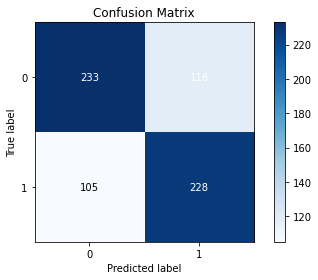

In [50]:
model3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4
#  scale_pos_weight=0.5,
)

y3_valid_preds, y3_test_preds = modelfit(model3, X_train, y_train, X_valid, y_valid)

cm_valid = confusion_matrix(y_valid, y3_valid_preds)
# cm_test = confusion_matrix(y_test, y3_test_preds)
classes = unique_labels(y_valid, y3_valid_preds)

plot_confusion(cm_valid, classes)

d:\Python\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report: 
Accuracy (valid): 0.6696
AUC Score (valid): 0.7392


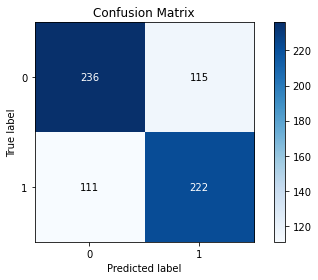

In [51]:
model5 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=120,
 max_depth=3,
 min_child_weight=1,
 gamma=0.3,
 subsample=1,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
)

y5_valid_preds, y5_test_preds = modelfit(model5, X_train, y_train, X_valid, y_valid)

cm_valid = confusion_matrix(y_valid, y5_valid_preds)
# cm_test = confusion_matrix(y_test, y5_test_preds)
classes = unique_labels(y_valid, y5_valid_preds)

plot_confusion(cm_valid, classes)

In [52]:
print(classification_report(y_valid, y1_valid_preds))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       351
           1       0.65      0.65      0.65       333

    accuracy                           0.66       684
   macro avg       0.66      0.66      0.66       684
weighted avg       0.66      0.66      0.66       684



In [53]:
print(classification_report(y_valid, y3_valid_preds))

              precision    recall  f1-score   support

           0       0.69      0.66      0.68       351
           1       0.66      0.68      0.67       333

    accuracy                           0.67       684
   macro avg       0.67      0.67      0.67       684
weighted avg       0.67      0.67      0.67       684



In [54]:
print(classification_report(y_valid, y5_valid_preds))

              precision    recall  f1-score   support

           0       0.68      0.67      0.68       351
           1       0.66      0.67      0.66       333

    accuracy                           0.67       684
   macro avg       0.67      0.67      0.67       684
weighted avg       0.67      0.67      0.67       684



In [55]:
model = model3

model.fit(np.array(X), np.array(label_encoded_y))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto', ...)

In [56]:
with open('../models/model.sav', 'wb') as f:
    pickle.dump(model, f)

In [57]:
with open('../models/model.sav', 'rb') as f:
    mdl = pickle.load(f)

In [58]:
mdl.predict(np.array(X[:40]))

array([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0])